In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.helpers import organise_data
from qe_model import *
from matplotlib import style
import scipy.stats as stats
from hurst import compute_Hc, random_walk
import math
import scipy.stats as st
import datetime
import pandas_datareader.data as web
#from functions.find_bubbles import *
import matplotlib.transforms as mtransforms

In [2]:
style.use('seaborn-ticks')

In [66]:
def confidence_interval(data):
    return st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data))

# Collect bond index data for validation

In [4]:
bond_index_tickers = ["BAMLCC0A0CMTRIV", "BAMLCC0A1AAATRIV", "BAMLCC0A2AATRIV", "BAMLCC0A3ATRIV", 
                     "BAMLCC0A4BBBTRIV", "BAMLCC1A013YTRIV", "BAMLCC2A035YTRIV", "BAMLCC3A057YTRIV",
                     "BAMLCC4A0710YTRIV", "BAMLCC7A01015YTRIV", "BAMLCC8A015PYTRIV", "BAMLEM1BRRAAA2ACRPITRIV", 
                      "BAMLEM1RAAA2ALCRPIUSTRIV", 
                      "BAMLHE00EHYITRIV", "BAMLHYH0A0HYM2TRIV", "BAMLHYH0A1BBTRIV","BAMLHYH0A2BTRIV", "BAMLHYH0A3CMTRIV"]

In [5]:
start = datetime.datetime(2010, 4, 17)
end = datetime.datetime(2018, 1, 31)

bondindices = web.DataReader(bond_index_tickers, "fred", start, end)

autocors_emp = pd.DataFrame()
for col in bondindices:
    autocors_emp[col] = [bondindices[col].pct_change().autocorr(lag=lag) for lag in range(25)]

Then, calculate confidence intervals for kurtosis, and autocorrelation + absolute autocorrelation of returns. 

In [6]:
lower_k, upper_k = confidence_interval(bondindices.pct_change().kurtosis())#, bondindices.pct_change().kurtosis().mean())

autocors_lower = []
autocors_upper = []

autocors_lows = []
autocors_highs = []

autocors_abs_lower = []
autocors_abs_upper = []

kurt_lower = []
kurt_upper = []
for i in range(len(autocors_emp)):
    autocors_lows.append(autocors_emp.iloc[i].min())
    autocors_highs.append(autocors_emp.iloc[i].max())
    
    lower, upper = confidence_interval(autocors_emp.iloc[i])#, autocors_emp.iloc[i].mean())
    autocors_lower.append(lower)
    autocors_upper.append(upper)
    
    abs_lower, abs_upper = confidence_interval(autocors_emp.abs().iloc[i])#, autocors_emp.abs().iloc[i].mean())
    autocors_abs_lower.append(abs_lower)
    autocors_abs_upper.append(abs_upper)

In [7]:
# calculate hursts
hursts = []
for col in bondindices:
    H, c, data = compute_Hc(bondindices[col].dropna(), kind='price', simplified=True)
    hursts.append(H)

In [8]:
confidence_interval(hursts)#, np.mean(hursts))

(0.6963834570601443, 0.7352450465409782)

# How CB balance sheet policies interact with asset cycles

In [9]:
NRUNS = 50
burn_in_period = 0

In [10]:
params_nb = {"fundamental_value": 166,
             "trader_sample_size": 22,
             "n_traders": 1000,
             "ticks": 600,
             "std_fundamental": 0.053,
             "init_assets": 740,
             'spread_max': 0.004,
             'money_multiplier': 2.2,
             "horizon": 200,
             "std_noise": 0.049,
             "w_random": 0.08,
             "strat_share_chartists": 0.08,
             "base_risk_aversion": 1.051,
             "fundamentalist_horizon_multiplier": 3.8,
             "trades_per_tick": 1, "mutation_intensity": 0.0477,
             "average_learning_ability": 0.05,
             "bond_mean_reversion": 0.0, 'cb_pf_range': 0.05,
             "qe_perc_size": 0.16, "cb_size": 0.02, "qe_asset_index": 0, "qe_start": 2, "qe_end":598}

In [11]:
with open('estimated_params.json', 'r') as f:
    est_params = json.loads(f.read())

In [13]:
problem = {
  'num_vars': 7,
  'names': ['std_noise', "w_random", "strat_share_chartists",
            "base_risk_aversion", "fundamentalist_horizon_multiplier",
            "mutation_intensity", "average_learning_ability"],
  'bounds': [[0.03, 0.09], [0.02, 0.15], [0.02, 0.3],
            [0.05, 3.0], [1.0, 5.0],
            [0.05,0.5], [0.01, 0.8]]
}

In [14]:
for i, name in enumerate(problem['names']):
    params_nb[name] = est_params[i]

In [15]:
scenarios = [None]
s_idx = 0

In [16]:
prices = []
fundamentals = []
volumes = []
qe_periods = []
qt_periods = []

for scenario in scenarios:
    trdrs = []
    orbs = []
    central_banks = []

    for seed_nb in range(NRUNS): 
        traders_nb, central_bank_nb, orderbook_nb = init_objects(params_nb, seed_nb)
        traders_nb, central_bank_nb, orderbook_nb = qe_model(traders_nb, central_bank_nb, orderbook_nb, params_nb, scenario=scenario, seed=seed_nb)
        central_banks.append(central_bank_nb)
        trdrs.append(traders_nb)
        orbs.append(orderbook_nb)
    
    prices.append(pd.DataFrame([orbs[run].tick_close_price for run in range(NRUNS)]).transpose())
    fundamentals.append(pd.DataFrame([orbs[run].fundamental for run in range(NRUNS)]).transpose())
    volumes.append(pd.DataFrame([[sum(v) for v in orbs[run].transaction_volumes_history] for run in range(NRUNS)]).transpose())
    qe_periods.append(pd.DataFrame([[orbs[run].qe_period] for run in range(NRUNS)]).transpose())
    qt_periods.append(pd.DataFrame([[orbs[run].qt_period] for run in range(NRUNS)]).transpose())

Start of simulation  0
201
202
203
cb QE
204
cb QE
205
cb QE
206
cb QE
207
cb QE
208
cb QE
209
cb QE
210
cb QE
211
cb QE
212
cb QE
213
cb QE
214
cb QE
215
cb QE
216
cb QE
217
cb QE
218
cb QE
219
cb QE
220
cb QE
221
cb QE
222
cb QE
223
cb QE
224
cb QE
225
cb QE
226
cb QE
227
cb QE
228
cb QE
229
cb QE
230
cb QE
231
cb QE
232
cb QE
233
cb QE
234
cb QE
235
cb QE
236
cb QE
237
cb QE
238
cb QE
239
cb QE
240
cb QE
241
cb QE
242
cb QE
243
cb QE
244
cb QE
245
cb QE
246
cb QE
247
cb QE
248
cb QE
249
cb QE
250
cb QE
251
cb QE
252
cb QE
253
cb QE
254
cb QE
255
cb QE
256
cb QE
257
cb QE
258
cb QE
259
cb QE
260
cb QE
261
cb QE
262
cb QE
263
cb QE
264
cb QE
265
cb QE
266
cb QE
267
cb QE
268
cb QE
269
cb QE
270
cb QE
271
cb QE
272
cb QE
273
cb QE
274
cb QE
275
cb QE
276
cb QE
277
cb QE
278
cb QE
279
cb QE
280
cb QE
281
cb QE
282
cb QE
283
cb QE
284
cb QE
285
cb QE
286
cb QE
287
cb QE
288
cb QE
289
cb QE
290
cb QE
291
cb QE
292
cb QE
293
cb QE
294
cb QE
295
cb QE
296
cb QE
297
cb QE
298
cb QE
299
cb QE

423
cb QE
424
cb QE
425
cb QE
426
cb QE
427
cb QE
428
cb QE
429
cb QE
430
cb QE
431
cb QE
432
cb QE
433
cb QE
434
cb QE
435
cb QE
436
cb QE
437
cb QE
438
cb QE
439
cb QE
440
cb QE
441
cb QE
442
cb QE
443
cb QE
444
cb QE
445
cb QE
446
cb QE
447
cb QE
448
cb QE
449
cb QE
450
cb QE
451
cb QE
452
cb QE
453
cb QE
454
cb QE
455
cb QE
456
cb QE
457
cb QE
458
cb QE
459
cb QE
460
cb QE
461
cb QE
462
cb QE
463
cb QE
464
cb QE
465
cb QE
466
cb QE
467
cb QE
468
cb QE
469
cb QE
470
cb QE
471
cb QE
472
cb QE
473
cb QE
474
cb QE
475
cb QE
476
cb QE
477
cb QE
478
cb QE
479
cb QE
480
cb QE
481
cb QE
482
cb QE
483
cb QE
484
cb QE
485
cb QE
486
cb QE
487
cb QE
488
cb QE
489
cb QE
490
cb QE
491
cb QE
492
cb QE
493
cb QE
494
cb QE
495
cb QE
496
cb QE
497
cb QE
498
cb QE
499
cb QE
500
cb QE
501
cb QE
502
cb QE
503
cb QE
504
cb QE
505
cb QE
506
cb QE
507
cb QE
508
cb QE
509
cb QE
510
cb QE
511
cb QE
512
cb QE
513
cb QE
514
cb QE
515
cb QE
516
cb QE
517
cb QE
518
cb QE
519
cb QE
520
cb QE
521
cb QE
522
cb QE


646
cb QE
647
cb QE
648
cb QE
649
cb QE
650
cb QE
651
cb QE
652
cb QE
653
cb QE
654
cb QE
655
cb QE
656
cb QE
657
cb QE
658
cb QE
659
cb QE
660
cb QE
661
cb QE
662
cb QE
663
cb QE
664
cb QE
665
cb QE
666
cb QE
667
cb QE
668
cb QE
669
cb QE
670
cb QE
671
cb QE
672
cb QE
673
cb QE
674
cb QE
675
cb QE
676
cb QE
677
cb QE
678
cb QE
679
cb QE
680
cb QE
681
cb QE
682
cb QE
683
cb QE
684
cb QE
685
cb QE
686
cb QE
687
cb QE
688
cb QE
689
cb QE
690
cb QE
691
cb QE
692
cb QE
693
cb QE
694
cb QE
695
cb QE
696
cb QE
697
cb QE
698
cb QE
699
cb QE
700
cb QE
701
cb QE
702
cb QE
703
cb QE
704
cb QE
705
cb QE
706
cb QE
707
cb QE
708
cb QE
709
cb QE
710
cb QE
711
cb QE
712
cb QE
713
cb QE
714
cb QE
715
cb QE
716
cb QE
717
cb QE
718
cb QE
719
cb QE
720
cb QE
721
cb QE
722
cb QE
723
cb QE
724
cb QE
725
cb QE
726
cb QE
727
cb QE
728
cb QE
729
cb QE
730
cb QE
731
cb QE
732
cb QE
733
cb QE
734
cb QE
735
cb QE
736
cb QE
737
cb QE
738
cb QE
739
cb QE
740
cb QE
741
cb QE
742
cb QE
743
cb QE
744
cb QE
745
cb QE


cb QE
265
cb QE
266
cb QE
267
cb QE
268
cb QE
269
cb QE
270
cb QE
271
cb QE
272
cb QE
273
cb QE
274
cb QE
275
cb QE
276
cb QE
277
cb QE
278
cb QE
279
cb QE
280
cb QE
281
cb QE
282
cb QE
283
cb QE
284
cb QE
285
cb QE
286
cb QE
287
cb QE
288
cb QE
289
cb QE
290
cb QE
291
cb QE
292
cb QE
293
cb QE
294
cb QE
295
cb QE
296
cb QE
297
cb QE
298
cb QE
299
cb QE
300
cb QE
301
cb QE
302
cb QE
303
cb QE
304
cb QE
305
cb QE
306
cb QE
307
cb QE
308
cb QE
309
cb QE
310
cb QE
311
cb QE
312
cb QE
313
cb QE
314
cb QE
315
cb QE
316
cb QE
317
cb QE
318
cb QE
319
cb QE
320
cb QE
321
cb QE
322
cb QE
323
cb QE
324
cb QE
325
cb QE
326
cb QE
327
cb QE
328
cb QE
329
cb QE
330
cb QE
331
cb QE
332
cb QE
333
cb QE
334
cb QE
335
cb QE
336
cb QE
337
cb QE
338
cb QE
339
cb QE
340
cb QE
341
cb QE
342
cb QE
343
cb QE
344
cb QE
345
cb QE
346
cb QE
347
cb QE
348
cb QE
349
cb QE
350
cb QE
351
cb QE
352
cb QE
353
cb QE
354
cb QE
355
cb QE
356
cb QE
357
cb QE
358
cb QE
359
cb QE
360
cb QE
361
cb QE
362
cb QE
363
cb QE
364


484
cb QE
485
cb QE
486
cb QE
487
cb QE
488
cb QE
489
cb QE
490
cb QE
491
cb QE
492
cb QE
493
cb QE
494
cb QE
495
cb QE
496
cb QE
497
cb QE
498
cb QE
499
cb QE
500
cb QE
501
cb QE
502
cb QE
503
cb QE
504
cb QE
505
cb QE
506
cb QE
507
cb QE
508
cb QE
509
cb QE
510
cb QE
511
cb QE
512
cb QE
513
cb QE
514
cb QE
515
cb QE
516
cb QE
517
cb QE
518
cb QE
519
cb QE
520
cb QE
521
cb QE
522
cb QE
523
cb QE
524
cb QE
525
cb QE
526
cb QE
527
cb QE
528
cb QE
529
cb QE
530
cb QE
531
cb QE
532
cb QE
533
cb QE
534
cb QE
535
cb QE
536
cb QE
537
cb QE
538
cb QE
539
cb QE
540
cb QE
541
cb QE
542
cb QE
543
cb QE
544
cb QE
545
cb QE
546
cb QE
547
cb QE
548
cb QE
549
cb QE
550
cb QE
551
cb QE
552
cb QE
553
cb QE
554
cb QE
555
cb QE
556
cb QE
557
cb QE
558
cb QE
559
cb QE
560
cb QE
561
cb QE
562
cb QE
563
cb QE
564
cb QE
565
cb QE
566
cb QE
567
cb QE
568
cb QE
569
cb QE
570
cb QE
571
cb QE
572
cb QE
573
cb QE
574
cb QE
575
cb QE
576
cb QE
577
cb QE
578
cb QE
579
cb QE
580
cb QE
581
cb QE
582
cb QE
583
cb QE


703
cb QE
704
cb QE
705
cb QE
706
cb QE
707
cb QE
708
cb QE
709
cb QE
710
cb QE
711
cb QE
712
cb QE
713
cb QE
714
cb QE
715
cb QE
716
cb QE
717
cb QE
718
cb QE
719
cb QE
720
cb QE
721
cb QE
722
cb QE
723
cb QE
724
cb QE
725
cb QE
726
cb QE
727
cb QE
728
cb QE
729
cb QE
730
cb QE
731
cb QE
732
cb QE
733
cb QE
734
cb QE
735
cb QE
736
cb QE
737
cb QE
738
cb QE
739
cb QE
740
cb QE
741
cb QE
742
cb QE
743
cb QE
744
cb QE
745
cb QE
746
cb QE
747
cb QE
748
cb QE
749
cb QE
750
cb QE
751
cb QE
752
cb QE
753
cb QE
754
cb QE
755
cb QE
756
cb QE
757
cb QE
758
cb QE
759
cb QE
760
cb QE
761
cb QE
762
cb QE
763
cb QE
764
cb QE
765
cb QE
766
cb QE
767
cb QE
768
cb QE
769
cb QE
770
cb QE
771
cb QE
772
cb QE
773
cb QE
774
cb QE
775
cb QE
776
cb QE
777
cb QE
778
cb QE
779
cb QE
780
cb QE
781
cb QE
782
cb QE
783
cb QE
784
cb QE
785
cb QE
786
cb QE
787
cb QE
788
cb QE
789
cb QE
790
cb QE
791
cb QE
792
cb QE
793
cb QE
794
cb QE
795
cb QE
796
cb QE
797
cb QE
798
cb QE
799
800
Start of simulation  7
201
202
2

325
cb QE
326
cb QE
327
cb QE
328
cb QE
329
cb QE
330
cb QE
331
cb QE
332
cb QE
333
cb QE
334
cb QE
335
cb QE
336
cb QE
337
cb QE
338
cb QE
339
cb QE
340
cb QE
341
cb QE
342
cb QE
343
cb QE
344
cb QE
345
cb QE
346
cb QE
347
cb QE
348
cb QE
349
cb QE
350
cb QE
351
cb QE
352
cb QE
353
cb QE
354
cb QE
355
cb QE
356
cb QE
357
cb QE
358
cb QE
359
cb QE
360
cb QE
361
cb QE
362
cb QE
363
cb QE
364
cb QE
365
cb QE
366
cb QE
367
cb QE
368
cb QE
369
cb QE
370
cb QE
371
cb QE
372
cb QE
373
cb QE
374
cb QE
375
cb QE
376
cb QE
377
cb QE
378
cb QE
379
cb QE
380
cb QE
381
cb QE
382
cb QE
383
cb QE
384
cb QE
385
cb QE
386
cb QE
387
cb QE
388
cb QE
389
cb QE
390
cb QE
391
cb QE
392
cb QE
393
cb QE
394
cb QE
395
cb QE
396
cb QE
397
cb QE
398
cb QE
399
cb QE
400
cb QE
401
cb QE
402
cb QE
403
cb QE
404
cb QE
405
cb QE
406
cb QE
407
cb QE
408
cb QE
409
cb QE
410
cb QE
411
cb QE
412
cb QE
413
cb QE
414
cb QE
415
cb QE
416
cb QE
417
cb QE
418
cb QE
419
cb QE
420
cb QE
421
cb QE
422
cb QE
423
cb QE
424
cb QE


547
cb QE
548
cb QE
549
cb QE
550
cb QE
551
cb QE
552
cb QE
553
cb QE
554
cb QE
555
cb QE
556
cb QE
557
cb QE
558
cb QE
559
cb QE
560
cb QE
561
cb QE
562
cb QE
563
cb QE
564
cb QE
565
cb QE
566
cb QE
567
cb QE
568
cb QE
569
cb QE
570
cb QE
571
cb QE
572
cb QE
573
cb QE
574
cb QE
575
cb QE
576
cb QE
577
cb QE
578
cb QE
579
cb QE
580
cb QE
581
cb QE
582
cb QE
583
cb QE
584
cb QE
585
cb QE
586
cb QE
587
cb QE
588
cb QE
589
cb QE
590
cb QE
591
cb QE
592
cb QE
593
cb QE
594
cb QE
595
cb QE
596
cb QE
597
cb QE
598
cb QE
599
cb QE
600
cb QE
601
cb QE
602
cb QE
603
cb QE
604
cb QE
605
cb QE
606
cb QE
607
cb QE
608
cb QE
609
cb QE
610
cb QE
611
cb QE
612
cb QE
613
cb QE
614
cb QE
615
cb QE
616
cb QE
617
cb QE
618
cb QE
619
cb QE
620
cb QE
621
cb QE
622
cb QE
623
cb QE
624
cb QE
625
cb QE
626
cb QE
627
cb QE
628
cb QE
629
cb QE
630
cb QE
631
cb QE
632
cb QE
633
cb QE
634
cb QE
635
cb QE
636
cb QE
637
cb QE
638
cb QE
639
cb QE
640
cb QE
641
cb QE
642
cb QE
643
cb QE
644
cb QE
645
cb QE
646
cb QE


770
cb QE
771
cb QE
772
cb QE
773
cb QE
774
cb QE
775
cb QE
776
cb QE
777
cb QE
778
cb QE
779
cb QE
780
cb QE
781
cb QE
782
cb QE
783
cb QE
784
cb QE
785
cb QE
786
cb QE
787
cb QE
788
cb QE
789
cb QE
790
cb QE
791
cb QE
792
cb QE
793
cb QE
794
cb QE
795
cb QE
796
cb QE
797
cb QE
798
cb QE
799
cb QE
800
Start of simulation  11
201
202
203
cb QE
204
cb QE
205
cb QE
206
cb QE
207
cb QE
208
cb QE
209
cb QE
210
cb QE
211
cb QE
212
cb QE
213
cb QE
214
cb QE
215
cb QE
216
cb QE
217
cb QE
218
cb QE
219
cb QE
220
cb QE
221
cb QE
222
cb QE
223
cb QE
224
cb QE
225
cb QE
226
cb QE
227
cb QE
228
cb QE
229
cb QE
230
cb QE
231
cb QE
232
cb QE
233
cb QE
234
cb QE
235
cb QE
236
cb QE
237
cb QE
238
cb QE
239
cb QE
240
cb QE
241
cb QE
242
cb QE
243
cb QE
244
cb QE
245
cb QE
246
cb QE
247
cb QE
248
cb QE
249
cb QE
250
cb QE
251
cb QE
252
cb QE
253
cb QE
254
cb QE
255
cb QE
256
cb QE
257
cb QE
258
cb QE
259
cb QE
260
cb QE
261
cb QE
262
cb QE
263
cb QE
264
cb QE
265
cb QE
266
cb QE
267
cb QE
268
cb QE
269


391
cb QE
392
cb QE
393
cb QE
394
cb QE
395
cb QE
396
cb QE
397
cb QE
398
cb QE
399
cb QE
400
cb QE
401
cb QE
402
cb QE
403
cb QE
404
cb QE
405
cb QE
406
cb QE
407
cb QE
408
cb QE
409
cb QE
410
cb QE
411
cb QE
412
cb QE
413
cb QE
414
cb QE
415
cb QE
416
cb QE
417
cb QE
418
cb QE
419
cb QE
420
cb QE
421
cb QE
422
cb QE
423
cb QE
424
cb QE
425
cb QE
426
cb QE
427
cb QE
428
cb QE
429
cb QE
430
cb QE
431
cb QE
432
cb QE
433
cb QE
434
cb QE
435
cb QE
436
cb QE
437
cb QE
438
cb QE
439
cb QE
440
cb QE
441
cb QE
442
cb QE
443
cb QE
444
cb QE
445
cb QE
446
cb QE
447
cb QE
448
cb QE
449
cb QE
450
cb QE
451
cb QE
452
cb QE
453
cb QE
454
cb QE
455
cb QE
456
cb QE
457
cb QE
458
cb QE
459
cb QE
460
cb QE
461
cb QE
462
cb QE
463
cb QE
464
cb QE
465
cb QE
466
cb QE
467
cb QE
468
cb QE
469
cb QE
470
cb QE
471
cb QE
472
cb QE
473
cb QE
474
cb QE
475
cb QE
476
cb QE
477
cb QE
478
cb QE
479
cb QE
480
cb QE
481
cb QE
482
cb QE
483
cb QE
484
cb QE
485
cb QE
486
cb QE
487
cb QE
488
cb QE
489
cb QE
490
cb QE


610
cb QE
611
cb QE
612
cb QE
613
cb QE
614
cb QE
615
cb QE
616
cb QE
617
cb QE
618
cb QE
619
cb QE
620
cb QE
621
cb QE
622
cb QE
623
cb QE
624
cb QE
625
cb QE
626
cb QE
627
cb QE
628
cb QE
629
cb QE
630
cb QE
631
cb QE
632
cb QE
633
cb QE
634
cb QE
635
cb QE
636
cb QE
637
cb QE
638
cb QE
639
cb QE
640
cb QE
641
cb QE
642
cb QE
643
cb QE
644
cb QE
645
cb QE
646
cb QE
647
cb QE
648
cb QE
649
cb QE
650
cb QE
651
cb QE
652
cb QE
653
cb QE
654
cb QE
655
cb QE
656
cb QE
657
cb QE
658
cb QE
659
cb QE
660
cb QE
661
cb QE
662
cb QE
663
cb QE
664
cb QE
665
cb QE
666
cb QE
667
cb QE
668
cb QE
669
cb QE
670
cb QE
671
cb QE
672
cb QE
673
cb QE
674
cb QE
675
cb QE
676
cb QE
677
cb QE
678
cb QE
679
cb QE
680
cb QE
681
cb QE
682
cb QE
683
cb QE
684
cb QE
685
cb QE
686
cb QE
687
cb QE
688
cb QE
689
cb QE
690
cb QE
691
cb QE
692
cb QE
693
cb QE
694
cb QE
695
cb QE
696
cb QE
697
cb QE
698
cb QE
699
cb QE
700
cb QE
701
cb QE
702
cb QE
703
cb QE
704
cb QE
705
cb QE
706
cb QE
707
cb QE
708
cb QE
709
cb QE


228
cb QE
229
cb QE
230
cb QE
231
cb QE
232
cb QE
233
cb QE
234
cb QE
235
cb QE
236
cb QE
237
cb QE
238
cb QE
239
cb QE
240
cb QE
241
cb QE
242
cb QE
243
cb QE
244
cb QE
245
cb QE
246
cb QE
247
cb QE
248
cb QE
249
cb QE
250
cb QE
251
cb QE
252
cb QE
253
cb QE
254
cb QE
255
cb QE
256
cb QE
257
cb QE
258
cb QE
259
cb QE
260
cb QE
261
cb QE
262
cb QE
263
cb QE
264
cb QE
265
cb QE
266
cb QE
267
cb QE
268
cb QE
269
cb QE
270
cb QE
271
cb QE
272
cb QE
273
cb QE
274
cb QE
275
cb QE
276
cb QE
277
cb QE
278
cb QE
279
cb QE
280
cb QE
281
cb QE
282
cb QE
283
cb QE
284
cb QE
285
cb QE
286
cb QE
287
cb QE
288
cb QE
289
cb QE
290
cb QE
291
cb QE
292
cb QE
293
cb QE
294
cb QE
295
cb QE
296
cb QE
297
cb QE
298
cb QE
299
cb QE
300
cb QE
301
cb QE
302
cb QE
303
cb QE
304
cb QE
305
cb QE
306
cb QE
307
cb QE
308
cb QE
309
cb QE
310
cb QE
311
cb QE
312
cb QE
313
cb QE
314
cb QE
315
cb QE
316
cb QE
317
cb QE
318
cb QE
319
cb QE
320
cb QE
321
cb QE
322
cb QE
323
cb QE
324
cb QE
325
cb QE
326
cb QE
327
cb QE


451
cb QE
452
cb QE
453
cb QE
454
cb QE
455
cb QE
456
cb QE
457
cb QE
458
cb QE
459
cb QE
460
cb QE
461
cb QE
462
cb QE
463
cb QE
464
cb QE
465
cb QE
466
cb QE
467
cb QE
468
cb QE
469
cb QE
470
cb QE
471
cb QE
472
cb QE
473
cb QE
474
cb QE
475
cb QE
476
cb QE
477
cb QE
478
cb QE
479
cb QE
480
cb QE
481
cb QE
482
cb QE
483
cb QE
484
cb QE
485
cb QE
486
cb QE
487
cb QE
488
cb QE
489
cb QE
490
cb QE
491
cb QE
492
cb QE
493
cb QE
494
cb QE
495
cb QE
496
cb QE
497
cb QE
498
cb QE
499
cb QE
500
cb QE
501
cb QE
502
cb QE
503
cb QE
504
cb QE
505
cb QE
506
cb QE
507
cb QE
508
cb QE
509
cb QE
510
cb QE
511
cb QE
512
cb QE
513
cb QE
514
cb QE
515
cb QE
516
cb QE
517
cb QE
518
cb QE
519
cb QE
520
cb QE
521
cb QE
522
cb QE
523
cb QE
524
cb QE
525
cb QE
526
cb QE
527
cb QE
528
cb QE
529
cb QE
530
cb QE
531
cb QE
532
cb QE
533
cb QE
534
cb QE
535
cb QE
536
cb QE
537
cb QE
538
cb QE
539
cb QE
540
cb QE
541
cb QE
542
cb QE
543
cb QE
544
cb QE
545
cb QE
546
cb QE
547
cb QE
548
cb QE
549
cb QE
550
cb QE


675
cb QE
676
cb QE
677
cb QE
678
cb QE
679
cb QE
680
cb QE
681
cb QE
682
cb QE
683
cb QE
684
cb QE
685
cb QE
686
cb QE
687
cb QE
688
cb QE
689
cb QE
690
cb QE
691
cb QE
692
cb QE
693
cb QE
694
cb QE
695
cb QE
696
cb QE
697
cb QE
698
cb QE
699
cb QE
700
cb QE
701
cb QE
702
cb QE
703
cb QE
704
cb QE
705
cb QE
706
cb QE
707
cb QE
708
cb QE
709
cb QE
710
cb QE
711
cb QE
712
cb QE
713
cb QE
714
cb QE
715
cb QE
716
cb QE
717
cb QE
718
cb QE
719
cb QE
720
cb QE
721
cb QE
722
cb QE
723
cb QE
724
cb QE
725
cb QE
726
cb QE
727
cb QE
728
cb QE
729
cb QE
730
cb QE
731
cb QE
732
cb QE
733
cb QE
734
cb QE
735
cb QE
736
cb QE
737
cb QE
738
cb QE
739
cb QE
740
cb QE
741
cb QE
742
cb QE
743
cb QE
744
cb QE
745
cb QE
746
cb QE
747
cb QE
748
cb QE
749
cb QE
750
cb QE
751
cb QE
752
cb QE
753
cb QE
754
cb QE
755
cb QE
756
cb QE
757
cb QE
758
cb QE
759
cb QE
760
cb QE
761
cb QE
762
cb QE
763
cb QE
764
cb QE
765
cb QE
766
cb QE
767
cb QE
768
cb QE
769
cb QE
770
cb QE
771
cb QE
772
cb QE
773
cb QE
774
cb QE


294
cb QE
295
cb QE
296
cb QE
297
cb QE
298
cb QE
299
cb QE
300
cb QE
301
cb QE
302
cb QE
303
cb QE
304
cb QE
305
cb QE
306
cb QE
307
cb QE
308
cb QE
309
cb QE
310
cb QE
311
cb QE
312
cb QE
313
cb QE
314
cb QE
315
cb QE
316
cb QE
317
cb QE
318
cb QE
319
cb QE
320
cb QE
321
cb QE
322
cb QE
323
cb QE
324
cb QE
325
cb QE
326
cb QE
327
cb QE
328
cb QE
329
cb QE
330
cb QE
331
cb QE
332
cb QE
333
cb QE
334
cb QE
335
cb QE
336
cb QE
337
cb QE
338
cb QE
339
cb QE
340
cb QE
341
cb QE
342
cb QE
343
cb QE
344
cb QE
345
cb QE
346
cb QE
347
cb QE
348
cb QE
349
cb QE
350
cb QE
351
cb QE
352
cb QE
353
cb QE
354
cb QE
355
cb QE
356
cb QE
357
cb QE
358
cb QE
359
cb QE
360
cb QE
361
cb QE
362
cb QE
363
cb QE
364
cb QE
365
cb QE
366
cb QE
367
cb QE
368
cb QE
369
cb QE
370
cb QE
371
cb QE
372
cb QE
373
cb QE
374
cb QE
375
cb QE
376
cb QE
377
cb QE
378
cb QE
379
cb QE
380
cb QE
381
cb QE
382
cb QE
383
cb QE
384
cb QE
385
cb QE
386
cb QE
387
cb QE
388
cb QE
389
cb QE
390
cb QE
391
cb QE
392
cb QE
393
cb QE


514
cb QE
515
cb QE
516
cb QE
517
cb QE
518
cb QE
519
cb QE
520
cb QE
521
cb QE
522
cb QE
523
cb QE
524
cb QE
525
cb QE
526
cb QE
527
cb QE
528
cb QE
529
cb QE
530
cb QE
531
cb QE
532
cb QE
533
cb QE
534
cb QE
535
cb QE
536
cb QE
537
cb QE
538
cb QE
539
cb QE
540
cb QE
541
cb QE
542
cb QE
543
cb QE
544
cb QE
545
cb QE
546
cb QE
547
cb QE
548
cb QE
549
cb QE
550
cb QE
551
cb QE
552
cb QE
553
cb QE
554
cb QE
555
cb QE
556
cb QE
557
cb QE
558
cb QE
559
cb QE
560
cb QE
561
cb QE
562
cb QE
563
cb QE
564
cb QE
565
cb QE
566
cb QE
567
cb QE
568
cb QE
569
cb QE
570
cb QE
571
cb QE
572
cb QE
573
cb QE
574
cb QE
575
cb QE
576
cb QE
577
cb QE
578
cb QE
579
cb QE
580
cb QE
581
cb QE
582
cb QE
583
cb QE
584
cb QE
585
cb QE
586
cb QE
587
cb QE
588
cb QE
589
cb QE
590
cb QE
591
cb QE
592
cb QE
593
cb QE
594
cb QE
595
cb QE
596
cb QE
597
cb QE
598
cb QE
599
cb QE
600
cb QE
601
cb QE
602
cb QE
603
cb QE
604
cb QE
605
cb QE
606
cb QE
607
cb QE
608
cb QE
609
cb QE
610
cb QE
611
cb QE
612
cb QE
613
cb QE


734
cb QE
735
cb QE
736
cb QE
737
cb QE
738
cb QE
739
cb QE
740
cb QE
741
cb QE
742
cb QE
743
cb QE
744
cb QE
745
cb QE
746
cb QE
747
cb QE
748
cb QE
749
cb QE
750
cb QE
751
cb QE
752
cb QE
753
cb QE
754
cb QE
755
cb QE
756
cb QE
757
cb QE
758
cb QE
759
cb QE
760
cb QE
761
cb QE
762
cb QE
763
cb QE
764
cb QE
765
cb QE
766
cb QE
767
cb QE
768
cb QE
769
cb QE
770
cb QE
771
cb QE
772
cb QE
773
cb QE
774
cb QE
775
cb QE
776
cb QE
777
cb QE
778
cb QE
779
cb QE
780
cb QE
781
cb QE
782
cb QE
783
cb QE
784
cb QE
785
cb QE
786
cb QE
787
cb QE
788
cb QE
789
cb QE
790
cb QE
791
cb QE
792
cb QE
793
cb QE
794
cb QE
795
cb QE
796
cb QE
797
cb QE
798
cb QE
799
800
Start of simulation  22
201
202
203
cb QE
204
cb QE
205
cb QE
206
cb QE
207
cb QE
208
cb QE
209
cb QE
210
cb QE
211
cb QE
212
cb QE
213
cb QE
214
cb QE
215
cb QE
216
cb QE
217
cb QE
218
cb QE
219
cb QE
220
cb QE
221
cb QE
222
cb QE
223
cb QE
224
cb QE
225
cb QE
226
cb QE
227
cb QE
228
cb QE
229
cb QE
230
cb QE
231
cb QE
232
cb QE
233
cb QE


353
cb QE
354
cb QE
355
cb QE
356
cb QE
357
cb QE
358
cb QE
359
cb QE
360
cb QE
361
cb QE
362
cb QE
363
cb QE
364
cb QE
365
cb QE
366
cb QE
367
cb QE
368
cb QE
369
cb QE
370
cb QE
371
cb QE
372
cb QE
373
cb QE
374
cb QE
375
cb QE
376
cb QE
377
cb QE
378
cb QE
379
cb QE
380
cb QE
381
cb QE
382
cb QE
383
cb QE
384
cb QE
385
cb QE
386
cb QE
387
cb QE
388
cb QE
389
cb QE
390
cb QE
391
cb QE
392
cb QE
393
cb QE
394
cb QE
395
cb QE
396
cb QE
397
cb QE
398
cb QE
399
cb QE
400
cb QE
401
cb QE
402
cb QE
403
cb QE
404
cb QE
405
cb QE
406
cb QE
407
cb QE
408
cb QE
409
cb QE
410
cb QE
411
cb QE
412
cb QE
413
cb QE
414
cb QE
415
cb QE
416
cb QE
417
cb QE
418
cb QE
419
cb QE
420
cb QE
421
cb QE
422
cb QE
423
cb QE
424
cb QE
425
cb QE
426
cb QE
427
cb QE
428
cb QE
429
cb QE
430
cb QE
431
cb QE
432
cb QE
433
cb QE
434
cb QE
435
cb QE
436
cb QE
437
cb QE
438
cb QE
439
cb QE
440
cb QE
441
cb QE
442
cb QE
443
cb QE
444
cb QE
445
cb QE
446
cb QE
447
cb QE
448
cb QE
449
cb QE
450
cb QE
451
cb QE
452
cb QE


573
cb QE
574
cb QE
575
cb QE
576
cb QE
577
cb QE
578
cb QE
579
cb QE
580
cb QE
581
cb QE
582
cb QE
583
cb QE
584
cb QE
585
cb QE
586
cb QE
587
cb QE
588
cb QE
589
cb QE
590
cb QE
591
cb QE
592
cb QE
593
cb QE
594
cb QE
595
cb QE
596
cb QE
597
cb QE
598
cb QE
599
cb QE
600
cb QE
601
cb QE
602
cb QE
603
cb QE
604
cb QE
605
cb QE
606
cb QE
607
cb QE
608
cb QE
609
cb QE
610
cb QE
611
cb QE
612
cb QE
613
cb QE
614
cb QE
615
cb QE
616
cb QE
617
cb QE
618
cb QE
619
cb QE
620
cb QE
621
cb QE
622
cb QE
623
cb QE
624
cb QE
625
cb QE
626
cb QE
627
cb QE
628
cb QE
629
cb QE
630
cb QE
631
cb QE
632
cb QE
633
cb QE
634
cb QE
635
cb QE
636
cb QE
637
cb QE
638
cb QE
639
cb QE
640
cb QE
641
cb QE
642
cb QE
643
cb QE
644
cb QE
645
cb QE
646
cb QE
647
cb QE
648
cb QE
649
cb QE
650
cb QE
651
cb QE
652
cb QE
653
cb QE
654
cb QE
655
cb QE
656
cb QE
657
cb QE
658
cb QE
659
cb QE
660
cb QE
661
cb QE
662
cb QE
663
cb QE
664
cb QE
665
cb QE
666
cb QE
667
cb QE
668
cb QE
669
cb QE
670
cb QE
671
cb QE
672
cb QE


792
cb QE
793
cb QE
794
cb QE
795
cb QE
796
cb QE
797
cb QE
798
cb QE
799
cb QE
800
cb QE
Start of simulation  26
201
202
203
cb QE
204
cb QE
205
cb QE
206
cb QE
207
cb QE
208
cb QE
209
cb QE
210
cb QE
211
cb QE
212
cb QE
213
cb QE
214
cb QE
215
cb QE
216
cb QE
217
cb QE
218
cb QE
219
cb QE
220
cb QE
221
cb QE
222
cb QE
223
cb QE
224
cb QE
225
cb QE
226
cb QE
227
cb QE
228
cb QE
229
cb QE
230
cb QE
231
cb QE
232
cb QE
233
cb QE
234
cb QE
235
cb QE
236
cb QE
237
cb QE
238
cb QE
239
cb QE
240
cb QE
241
cb QE
242
cb QE
243
cb QE
244
cb QE
245
cb QE
246
cb QE
247
cb QE
248
cb QE
249
cb QE
250
cb QE
251
cb QE
252
cb QE
253
cb QE
254
cb QE
255
cb QE
256
cb QE
257
cb QE
258
cb QE
259
cb QE
260
cb QE
261
cb QE
262
cb QE
263
cb QE
264
cb QE
265
cb QE
266
cb QE
267
cb QE
268
cb QE
269
cb QE
270
cb QE
271
cb QE
272
cb QE
273
cb QE
274
cb QE
275
cb QE
276
cb QE
277
cb QE
278
cb QE
279
cb QE
280
cb QE
281
cb QE
282
cb QE
283
cb QE
284
cb QE
285
cb QE
286
cb QE
287
cb QE
288
cb QE
289
cb QE
290
cb Q

416
cb QE
417
cb QE
418
cb QE
419
cb QE
420
cb QE
421
cb QE
422
cb QE
423
cb QE
424
cb QE
425
cb QE
426
cb QE
427
cb QE
428
cb QE
429
cb QE
430
cb QE
431
cb QE
432
cb QE
433
cb QE
434
cb QE
435
cb QE
436
cb QE
437
cb QE
438
cb QE
439
cb QE
440
cb QE
441
cb QE
442
cb QE
443
cb QE
444
cb QE
445
cb QE
446
cb QE
447
cb QE
448
cb QE
449
cb QE
450
cb QE
451
cb QE
452
cb QE
453
cb QE
454
cb QE
455
cb QE
456
cb QE
457
cb QE
458
cb QE
459
cb QE
460
cb QE
461
cb QE
462
cb QE
463
cb QE
464
cb QE
465
cb QE
466
cb QE
467
cb QE
468
cb QE
469
cb QE
470
cb QE
471
cb QE
472
cb QE
473
cb QE
474
cb QE
475
cb QE
476
cb QE
477
cb QE
478
cb QE
479
cb QE
480
cb QE
481
cb QE
482
cb QE
483
cb QE
484
cb QE
485
cb QE
486
cb QE
487
cb QE
488
cb QE
489
cb QE
490
cb QE
491
cb QE
492
cb QE
493
cb QE
494
cb QE
495
cb QE
496
cb QE
497
cb QE
498
cb QE
499
cb QE
500
cb QE
501
cb QE
502
cb QE
503
cb QE
504
cb QE
505
cb QE
506
cb QE
507
cb QE
508
cb QE
509
cb QE
510
cb QE
511
cb QE
512
cb QE
513
cb QE
514
cb QE
515
cb QE


636
cb QE
637
cb QE
638
cb QE
639
cb QE
640
cb QE
641
cb QE
642
cb QE
643
cb QE
644
cb QE
645
cb QE
646
cb QE
647
cb QE
648
cb QE
649
cb QE
650
cb QE
651
cb QE
652
cb QE
653
cb QE
654
cb QE
655
cb QE
656
cb QE
657
cb QE
658
cb QE
659
cb QE
660
cb QE
661
cb QE
662
cb QE
663
cb QE
664
cb QE
665
cb QE
666
cb QE
667
cb QE
668
cb QE
669
cb QE
670
cb QE
671
cb QE
672
cb QE
673
cb QE
674
cb QE
675
cb QE
676
cb QE
677
cb QE
678
cb QE
679
cb QE
680
cb QE
681
cb QE
682
cb QE
683
cb QE
684
cb QE
685
cb QE
686
cb QE
687
cb QE
688
cb QE
689
cb QE
690
cb QE
691
cb QE
692
cb QE
693
cb QE
694
cb QE
695
cb QE
696
cb QE
697
cb QE
698
cb QE
699
cb QE
700
cb QE
701
cb QE
702
cb QE
703
cb QE
704
cb QE
705
cb QE
706
cb QE
707
cb QE
708
cb QE
709
cb QE
710
cb QE
711
cb QE
712
cb QE
713
cb QE
714
cb QE
715
cb QE
716
cb QE
717
cb QE
718
cb QE
719
cb QE
720
cb QE
721
cb QE
722
cb QE
723
cb QE
724
cb QE
725
cb QE
726
cb QE
727
cb QE
728
cb QE
729
cb QE
730
cb QE
731
cb QE
732
cb QE
733
cb QE
734
cb QE
735
cb QE


254
cb QE
255
cb QE
256
cb QE
257
cb QE
258
cb QE
259
cb QE
260
cb QE
261
cb QE
262
cb QE
263
cb QE
264
cb QE
265
cb QE
266
cb QE
267
cb QE
268
cb QE
269
cb QE
270
cb QE
271
cb QE
272
cb QE
273
cb QE
274
cb QE
275
cb QE
276
cb QE
277
cb QE
278
cb QE
279
cb QE
280
cb QE
281
cb QE
282
cb QE
283
cb QE
284
cb QE
285
cb QE
286
cb QE
287
cb QE
288
cb QE
289
cb QE
290
cb QE
291
cb QE
292
cb QE
293
cb QE
294
cb QE
295
cb QE
296
cb QE
297
cb QE
298
cb QE
299
cb QE
300
cb QE
301
cb QE
302
cb QE
303
cb QE
304
cb QE
305
cb QE
306
cb QE
307
cb QE
308
cb QE
309
cb QE
310
cb QE
311
cb QE
312
cb QE
313
cb QE
314
cb QE
315
cb QE
316
cb QE
317
cb QE
318
cb QE
319
cb QE
320
cb QE
321
cb QE
322
cb QE
323
cb QE
324
cb QE
325
cb QE
326
cb QE
327
cb QE
328
cb QE
329
cb QE
330
cb QE
331
cb QE
332
cb QE
333
cb QE
334
cb QE
335
cb QE
336
cb QE
337
cb QE
338
cb QE
339
cb QE
340
cb QE
341
cb QE
342
cb QE
343
cb QE
344
cb QE
345
cb QE
346
cb QE
347
cb QE
348
cb QE
349
cb QE
350
cb QE
351
cb QE
352
cb QE
353
cb QE


474
cb QE
475
cb QE
476
cb QE
477
cb QE
478
cb QE
479
cb QE
480
cb QE
481
cb QE
482
cb QE
483
cb QE
484
cb QE
485
cb QE
486
cb QE
487
cb QE
488
cb QE
489
cb QE
490
cb QE
491
cb QE
492
cb QE
493
cb QE
494
cb QE
495
cb QE
496
cb QE
497
cb QE
498
cb QE
499
cb QE
500
cb QE
501
cb QE
502
cb QE
503
cb QE
504
cb QE
505
cb QE
506
cb QE
507
cb QE
508
cb QE
509
cb QE
510
cb QE
511
cb QE
512
cb QE
513
cb QE
514
cb QE
515
cb QE
516
cb QE
517
cb QE
518
cb QE
519
cb QE
520
cb QE
521
cb QE
522
cb QE
523
cb QE
524
cb QE
525
cb QE
526
cb QE
527
cb QE
528
cb QE
529
cb QE
530
cb QE
531
cb QE
532
cb QE
533
cb QE
534
cb QE
535
cb QE
536
cb QE
537
cb QE
538
cb QE
539
cb QE
540
cb QE
541
cb QE
542
cb QE
543
cb QE
544
cb QE
545
cb QE
546
cb QE
547
cb QE
548
cb QE
549
cb QE
550
cb QE
551
cb QE
552
cb QE
553
cb QE
554
cb QE
555
cb QE
556
cb QE
557
cb QE
558
cb QE
559
cb QE
560
cb QE
561
cb QE
562
cb QE
563
cb QE
564
cb QE
565
cb QE
566
cb QE
567
cb QE
568
cb QE
569
cb QE
570
cb QE
571
cb QE
572
cb QE
573
cb QE


695
cb QE
696
cb QE
697
cb QE
698
cb QE
699
cb QE
700
cb QE
701
cb QE
702
cb QE
703
cb QE
704
cb QE
705
cb QE
706
cb QE
707
cb QE
708
cb QE
709
cb QE
710
cb QE
711
cb QE
712
cb QE
713
cb QE
714
cb QE
715
cb QE
716
cb QE
717
cb QE
718
cb QE
719
cb QE
720
cb QE
721
cb QE
722
cb QE
723
cb QE
724
cb QE
725
cb QE
726
cb QE
727
cb QE
728
cb QE
729
cb QE
730
cb QE
731
cb QE
732
cb QE
733
cb QE
734
cb QE
735
cb QE
736
cb QE
737
cb QE
738
cb QE
739
cb QE
740
cb QE
741
cb QE
742
cb QE
743
cb QE
744
cb QE
745
cb QE
746
cb QE
747
cb QE
748
cb QE
749
cb QE
750
cb QE
751
cb QE
752
cb QE
753
cb QE
754
cb QE
755
cb QE
756
cb QE
757
cb QE
758
cb QE
759
cb QE
760
cb QE
761
cb QE
762
cb QE
763
cb QE
764
cb QE
765
cb QE
766
cb QE
767
cb QE
768
cb QE
769
cb QE
770
cb QE
771
cb QE
772
cb QE
773
cb QE
774
cb QE
775
cb QE
776
cb QE
777
cb QE
778
cb QE
779
cb QE
780
cb QE
781
cb QE
782
cb QE
783
cb QE
784
cb QE
785
cb QE
786
cb QE
787
cb QE
788
cb QE
789
cb QE
790
cb QE
791
cb QE
792
cb QE
793
cb QE
794
cb QE


316
cb QE
317
cb QE
318
cb QE
319
cb QE
320
cb QE
321
cb QE
322
cb QE
323
cb QE
324
cb QE
325
cb QE
326
cb QE
327
cb QE
328
cb QE
329
cb QE
330
cb QE
331
cb QE
332
cb QE
333
cb QE
334
cb QE
335
cb QE
336
cb QE
337
cb QE
338
cb QE
339
cb QE
340
cb QE
341
cb QE
342
cb QE
343
cb QE
344
cb QE
345
cb QE
346
cb QE
347
cb QE
348
cb QE
349
cb QE
350
cb QE
351
cb QE
352
cb QE
353
cb QE
354
cb QE
355
cb QE
356
cb QE
357
cb QE
358
cb QE
359
cb QE
360
cb QE
361
cb QE
362
cb QE
363
cb QE
364
cb QE
365
cb QE
366
cb QE
367
cb QE
368
cb QE
369
cb QE
370
cb QE
371
cb QE
372
cb QE
373
cb QE
374
cb QE
375
cb QE
376
cb QE
377
cb QE
378
cb QE
379
cb QE
380
cb QE
381
cb QE
382
cb QE
383
cb QE
384
cb QE
385
cb QE
386
cb QE
387
cb QE
388
cb QE
389
cb QE
390
cb QE
391
cb QE
392
cb QE
393
cb QE
394
cb QE
395
cb QE
396
cb QE
397
cb QE
398
cb QE
399
cb QE
400
cb QE
401
cb QE
402
cb QE
403
cb QE
404
cb QE
405
cb QE
406
cb QE
407
cb QE
408
cb QE
409
cb QE
410
cb QE
411
cb QE
412
cb QE
413
cb QE
414
cb QE
415
cb QE


540
cb QE
541
cb QE
542
cb QE
543
cb QE
544
cb QE
545
cb QE
546
cb QE
547
cb QE
548
cb QE
549
cb QE
550
cb QE
551
cb QE
552
cb QE
553
cb QE
554
cb QE
555
cb QE
556
cb QE
557
cb QE
558
cb QE
559
cb QE
560
cb QE
561
cb QE
562
cb QE
563
cb QE
564
cb QE
565
cb QE
566
cb QE
567
cb QE
568
cb QE
569
cb QE
570
cb QE
571
cb QE
572
cb QE
573
cb QE
574
cb QE
575
cb QE
576
cb QE
577
cb QE
578
cb QE
579
cb QE
580
cb QE
581
cb QE
582
cb QE
583
cb QE
584
cb QE
585
cb QE
586
cb QE
587
cb QE
588
cb QE
589
cb QE
590
cb QE
591
cb QE
592
cb QE
593
cb QE
594
cb QE
595
cb QE
596
cb QE
597
cb QE
598
cb QE
599
cb QE
600
cb QE
601
cb QE
602
cb QE
603
cb QE
604
cb QE
605
cb QE
606
cb QE
607
cb QE
608
cb QE
609
cb QE
610
cb QE
611
cb QE
612
cb QE
613
cb QE
614
cb QE
615
cb QE
616
cb QE
617
cb QE
618
cb QE
619
cb QE
620
cb QE
621
cb QE
622
cb QE
623
cb QE
624
cb QE
625
cb QE
626
cb QE
627
cb QE
628
cb QE
629
cb QE
630
cb QE
631
cb QE
632
cb QE
633
cb QE
634
cb QE
635
cb QE
636
cb QE
637
cb QE
638
cb QE
639
cb QE


765
cb QE
766
cb QE
767
cb QE
768
cb QE
769
cb QE
770
cb QE
771
cb QE
772
cb QE
773
cb QE
774
cb QE
775
cb QE
776
cb QE
777
cb QE
778
cb QE
779
cb QE
780
cb QE
781
cb QE
782
cb QE
783
cb QE
784
cb QE
785
cb QE
786
cb QE
787
cb QE
788
cb QE
789
cb QE
790
cb QE
791
cb QE
792
cb QE
793
cb QE
794
cb QE
795
cb QE
796
cb QE
797
cb QE
798
cb QE
799
cb QE
800
Start of simulation  37
201
202
203
cb QE
204
cb QE
205
cb QE
206
cb QE
207
cb QE
208
cb QE
209
cb QE
210
cb QE
211
cb QE
212
cb QE
213
cb QE
214
cb QE
215
cb QE
216
cb QE
217
cb QE
218
cb QE
219
cb QE
220
cb QE
221
cb QE
222
cb QE
223
cb QE
224
cb QE
225
cb QE
226
cb QE
227
cb QE
228
cb QE
229
cb QE
230
cb QE
231
cb QE
232
cb QE
233
cb QE
234
cb QE
235
cb QE
236
cb QE
237
cb QE
238
cb QE
239
cb QE
240
cb QE
241
cb QE
242
cb QE
243
cb QE
244
cb QE
245
cb QE
246
cb QE
247
cb QE
248
cb QE
249
cb QE
250
cb QE
251
cb QE
252
cb QE
253
cb QE
254
cb QE
255
cb QE
256
cb QE
257
cb QE
258
cb QE
259
cb QE
260
cb QE
261
cb QE
262
cb QE
263
cb QE
264


387
cb QE
388
cb QE
389
cb QE
390
cb QE
391
cb QE
392
cb QE
393
cb QE
394
cb QE
395
cb QE
396
cb QE
397
cb QE
398
cb QE
399
cb QE
400
cb QE
401
cb QE
402
cb QE
403
cb QE
404
cb QE
405
cb QE
406
cb QE
407
cb QE
408
cb QE
409
cb QE
410
cb QE
411
cb QE
412
cb QE
413
cb QE
414
cb QE
415
cb QE
416
cb QE
417
cb QE
418
cb QE
419
cb QE
420
cb QE
421
cb QE
422
cb QE
423
cb QE
424
cb QE
425
cb QE
426
cb QE
427
cb QE
428
cb QE
429
cb QE
430
cb QE
431
cb QE
432
cb QE
433
cb QE
434
cb QE
435
cb QE
436
cb QE
437
cb QE
438
cb QE
439
cb QE
440
cb QE
441
cb QE
442
cb QE
443
cb QE
444
cb QE
445
cb QE
446
cb QE
447
cb QE
448
cb QE
449
cb QE
450
cb QE
451
cb QE
452
cb QE
453
cb QE
454
cb QE
455
cb QE
456
cb QE
457
cb QE
458
cb QE
459
cb QE
460
cb QE
461
cb QE
462
cb QE
463
cb QE
464
cb QE
465
cb QE
466
cb QE
467
cb QE
468
cb QE
469
cb QE
470
cb QE
471
cb QE
472
cb QE
473
cb QE
474
cb QE
475
cb QE
476
cb QE
477
cb QE
478
cb QE
479
cb QE
480
cb QE
481
cb QE
482
cb QE
483
cb QE
484
cb QE
485
cb QE
486
cb QE


606
cb QE
607
cb QE
608
cb QE
609
cb QE
610
cb QE
611
cb QE
612
cb QE
613
cb QE
614
cb QE
615
cb QE
616
cb QE
617
cb QE
618
cb QE
619
cb QE
620
cb QE
621
cb QE
622
cb QE
623
cb QE
624
cb QE
625
cb QE
626
cb QE
627
cb QE
628
cb QE
629
cb QE
630
cb QE
631
cb QE
632
cb QE
633
cb QE
634
cb QE
635
cb QE
636
cb QE
637
cb QE
638
cb QE
639
cb QE
640
cb QE
641
cb QE
642
cb QE
643
cb QE
644
cb QE
645
cb QE
646
cb QE
647
cb QE
648
cb QE
649
cb QE
650
cb QE
651
cb QE
652
cb QE
653
cb QE
654
cb QE
655
cb QE
656
cb QE
657
cb QE
658
cb QE
659
cb QE
660
cb QE
661
cb QE
662
cb QE
663
cb QE
664
cb QE
665
cb QE
666
cb QE
667
cb QE
668
cb QE
669
cb QE
670
cb QE
671
cb QE
672
cb QE
673
cb QE
674
cb QE
675
cb QE
676
cb QE
677
cb QE
678
cb QE
679
cb QE
680
cb QE
681
cb QE
682
cb QE
683
cb QE
684
cb QE
685
cb QE
686
cb QE
687
cb QE
688
cb QE
689
cb QE
690
cb QE
691
cb QE
692
cb QE
693
cb QE
694
cb QE
695
cb QE
696
cb QE
697
cb QE
698
cb QE
699
cb QE
700
cb QE
701
cb QE
702
cb QE
703
cb QE
704
cb QE
705
cb QE


229
cb QE
230
cb QE
231
cb QE
232
cb QE
233
cb QE
234
cb QE
235
cb QE
236
cb QE
237
cb QE
238
cb QE
239
cb QE
240
cb QE
241
cb QE
242
cb QE
243
cb QE
244
cb QE
245
cb QE
246
cb QE
247
cb QE
248
cb QE
249
cb QE
250
cb QE
251
cb QE
252
cb QE
253
cb QE
254
cb QE
255
cb QE
256
cb QE
257
cb QE
258
cb QE
259
cb QE
260
cb QE
261
cb QE
262
cb QE
263
cb QE
264
cb QE
265
cb QE
266
cb QE
267
cb QE
268
cb QE
269
cb QE
270
cb QE
271
cb QE
272
cb QE
273
cb QE
274
cb QE
275
cb QE
276
cb QE
277
cb QE
278
cb QE
279
cb QE
280
cb QE
281
cb QE
282
cb QE
283
cb QE
284
cb QE
285
cb QE
286
cb QE
287
cb QE
288
cb QE
289
cb QE
290
cb QE
291
cb QE
292
cb QE
293
cb QE
294
cb QE
295
cb QE
296
cb QE
297
cb QE
298
cb QE
299
cb QE
300
cb QE
301
cb QE
302
cb QE
303
cb QE
304
cb QE
305
cb QE
306
cb QE
307
cb QE
308
cb QE
309
cb QE
310
cb QE
311
cb QE
312
cb QE
313
cb QE
314
cb QE
315
cb QE
316
cb QE
317
cb QE
318
cb QE
319
cb QE
320
cb QE
321
cb QE
322
cb QE
323
cb QE
324
cb QE
325
cb QE
326
cb QE
327
cb QE
328
cb QE


cb QE
453
cb QE
454
cb QE
455
cb QE
456
cb QE
457
cb QE
458
cb QE
459
cb QE
460
cb QE
461
cb QE
462
cb QE
463
cb QE
464
cb QE
465
cb QE
466
cb QE
467
cb QE
468
cb QE
469
cb QE
470
cb QE
471
cb QE
472
cb QE
473
cb QE
474
cb QE
475
cb QE
476
cb QE
477
cb QE
478
cb QE
479
cb QE
480
cb QE
481
cb QE
482
cb QE
483
cb QE
484
cb QE
485
cb QE
486
cb QE
487
cb QE
488
cb QE
489
cb QE
490
cb QE
491
cb QE
492
cb QE
493
cb QE
494
cb QE
495
cb QE
496
cb QE
497
cb QE
498
cb QE
499
cb QE
500
cb QE
501
cb QE
502
cb QE
503
cb QE
504
cb QE
505
cb QE
506
cb QE
507
cb QE
508
cb QE
509
cb QE
510
cb QE
511
cb QE
512
cb QE
513
cb QE
514
cb QE
515
cb QE
516
cb QE
517
cb QE
518
cb QE
519
cb QE
520
cb QE
521
cb QE
522
cb QE
523
cb QE
524
cb QE
525
cb QE
526
cb QE
527
cb QE
528
cb QE
529
cb QE
530
cb QE
531
cb QE
532
cb QE
533
cb QE
534
cb QE
535
cb QE
536
cb QE
537
cb QE
538
cb QE
539
cb QE
540
cb QE
541
cb QE
542
cb QE
543
cb QE
544
cb QE
545
cb QE
546
cb QE
547
cb QE
548
cb QE
549
cb QE
550
cb QE
551
cb QE
552


675
cb QE
676
cb QE
677
cb QE
678
cb QE
679
cb QE
680
cb QE
681
cb QE
682
cb QE
683
cb QE
684
cb QE
685
cb QE
686
cb QE
687
cb QE
688
cb QE
689
cb QE
690
cb QE
691
cb QE
692
cb QE
693
cb QE
694
cb QE
695
cb QE
696
cb QE
697
cb QE
698
cb QE
699
cb QE
700
cb QE
701
cb QE
702
cb QE
703
cb QE
704
cb QE
705
cb QE
706
cb QE
707
cb QE
708
cb QE
709
cb QE
710
cb QE
711
cb QE
712
cb QE
713
cb QE
714
cb QE
715
cb QE
716
cb QE
717
cb QE
718
cb QE
719
cb QE
720
cb QE
721
cb QE
722
cb QE
723
cb QE
724
cb QE
725
cb QE
726
cb QE
727
cb QE
728
cb QE
729
cb QE
730
cb QE
731
cb QE
732
cb QE
733
cb QE
734
cb QE
735
cb QE
736
cb QE
737
cb QE
738
cb QE
739
cb QE
740
cb QE
741
cb QE
742
cb QE
743
cb QE
744
cb QE
745
cb QE
746
cb QE
747
cb QE
748
cb QE
749
cb QE
750
cb QE
751
cb QE
752
cb QE
753
cb QE
754
cb QE
755
cb QE
756
cb QE
757
cb QE
758
cb QE
759
cb QE
760
cb QE
761
cb QE
762
cb QE
763
cb QE
764
cb QE
765
cb QE
766
cb QE
767
cb QE
768
cb QE
769
cb QE
770
cb QE
771
cb QE
772
cb QE
773
cb QE
774
cb QE


299
cb QE
300
cb QE
301
cb QE
302
cb QE
303
cb QE
304
cb QE
305
cb QE
306
cb QE
307
cb QE
308
cb QE
309
cb QE
310
cb QE
311
cb QE
312
cb QE
313
cb QE
314
cb QE
315
cb QE
316
cb QE
317
cb QE
318
cb QE
319
cb QE
320
cb QE
321
cb QE
322
cb QE
323
cb QE
324
cb QE
325
cb QE
326
cb QE
327
cb QE
328
cb QE
329
cb QE
330
cb QE
331
cb QE
332
cb QE
333
cb QE
334
cb QE
335
cb QE
336
cb QE
337
cb QE
338
cb QE
339
cb QE
340
cb QE
341
cb QE
342
cb QE
343
cb QE
344
cb QE
345
cb QE
346
cb QE
347
cb QE
348
cb QE
349
cb QE
350
cb QE
351
cb QE
352
cb QE
353
cb QE
354
cb QE
355
cb QE
356
cb QE
357
cb QE
358
cb QE
359
cb QE
360
cb QE
361
cb QE
362
cb QE
363
cb QE
364
cb QE
365
cb QE
366
cb QE
367
cb QE
368
cb QE
369
cb QE
370
cb QE
371
cb QE
372
cb QE
373
cb QE
374
cb QE
375
cb QE
376
cb QE
377
cb QE
378
cb QE
379
cb QE
380
cb QE
381
cb QE
382
cb QE
383
cb QE
384
cb QE
385
cb QE
386
cb QE
387
cb QE
388
cb QE
389
cb QE
390
cb QE
391
cb QE
392
cb QE
393
cb QE
394
cb QE
395
cb QE
396
cb QE
397
cb QE
398
cb QE


523
cb QE
524
cb QE
525
cb QE
526
cb QE
527
cb QE
528
cb QE
529
cb QE
530
cb QE
531
cb QE
532
cb QE
533
cb QE
534
cb QE
535
cb QE
536
cb QE
537
cb QE
538
cb QE
539
cb QE
540
cb QE
541
cb QE
542
cb QE
543
cb QE
544
cb QE
545
cb QE
546
cb QE
547
cb QE
548
cb QE
549
cb QE
550
cb QE
551
cb QE
552
cb QE
553
cb QE
554
cb QE
555
cb QE
556
cb QE
557
cb QE
558
cb QE
559
cb QE
560
cb QE
561
cb QE
562
cb QE
563
cb QE
564
cb QE
565
cb QE
566
cb QE
567
cb QE
568
cb QE
569
cb QE
570
cb QE
571
cb QE
572
cb QE
573
cb QE
574
cb QE
575
cb QE
576
cb QE
577
cb QE
578
cb QE
579
cb QE
580
cb QE
581
cb QE
582
cb QE
583
cb QE
584
cb QE
585
cb QE
586
cb QE
587
cb QE
588
cb QE
589
cb QE
590
cb QE
591
cb QE
592
cb QE
593
cb QE
594
cb QE
595
cb QE
596
cb QE
597
cb QE
598
cb QE
599
cb QE
600
cb QE
601
cb QE
602
cb QE
603
cb QE
604
cb QE
605
cb QE
606
cb QE
607
cb QE
608
cb QE
609
cb QE
610
cb QE
611
cb QE
612
cb QE
613
cb QE
614
cb QE
615
cb QE
616
cb QE
617
cb QE
618
cb QE
619
cb QE
620
cb QE
621
cb QE
622
cb QE


743
cb QE
744
cb QE
745
cb QE
746
cb QE
747
cb QE
748
cb QE
749
cb QE
750
cb QE
751
cb QE
752
cb QE
753
cb QE
754
cb QE
755
cb QE
756
cb QE
757
cb QE
758
cb QE
759
cb QE
760
cb QE
761
cb QE
762
cb QE
763
cb QE
764
cb QE
765
cb QE
766
cb QE
767
cb QE
768
cb QE
769
cb QE
770
cb QE
771
cb QE
772
cb QE
773
cb QE
774
cb QE
775
cb QE
776
cb QE
777
cb QE
778
cb QE
779
cb QE
780
cb QE
781
cb QE
782
cb QE
783
cb QE
784
cb QE
785
cb QE
786
cb QE
787
cb QE
788
cb QE
789
cb QE
790
cb QE
791
cb QE
792
cb QE
793
cb QE
794
cb QE
795
cb QE
796
cb QE
797
cb QE
798
cb QE
799
800
Start of simulation  48
201
202
203
cb QE
204
cb QE
205
cb QE
206
cb QE
207
cb QE
208
cb QE
209
cb QE
210
cb QE
211
cb QE
212
cb QE
213
cb QE
214
cb QE
215
cb QE
216
cb QE
217
cb QE
218
cb QE
219
cb QE
220
cb QE
221
cb QE
222
cb QE
223
cb QE
224
cb QE
225
cb QE
226
cb QE
227
cb QE
228
cb QE
229
cb QE
230
cb QE
231
cb QE
232
cb QE
233
cb QE
234
cb QE
235
cb QE
236
cb QE
237
cb QE
238
cb QE
239
cb QE
240
cb QE
241
cb QE
242
cb QE


363
cb QE
364
cb QE
365
cb QE
366
cb QE
367
cb QE
368
cb QE
369
cb QE
370
cb QE
371
cb QE
372
cb QE
373
cb QE
374
cb QE
375
cb QE
376
cb QE
377
cb QE
378
cb QE
379
cb QE
380
cb QE
381
cb QE
382
cb QE
383
cb QE
384
cb QE
385
cb QE
386
cb QE
387
cb QE
388
cb QE
389
cb QE
390
cb QE
391
cb QE
392
cb QE
393
cb QE
394
cb QE
395
cb QE
396
cb QE
397
cb QE
398
cb QE
399
cb QE
400
cb QE
401
cb QE
402
cb QE
403
cb QE
404
cb QE
405
cb QE
406
cb QE
407
cb QE
408
cb QE
409
cb QE
410
cb QE
411
cb QE
412
cb QE
413
cb QE
414
cb QE
415
cb QE
416
cb QE
417
cb QE
418
cb QE
419
cb QE
420
cb QE
421
cb QE
422
cb QE
423
cb QE
424
cb QE
425
cb QE
426
cb QE
427
cb QE
428
cb QE
429
cb QE
430
cb QE
431
cb QE
432
cb QE
433
cb QE
434
cb QE
435
cb QE
436
cb QE
437
cb QE
438
cb QE
439
cb QE
440
cb QE
441
cb QE
442
cb QE
443
cb QE
444
cb QE
445
cb QE
446
cb QE
447
cb QE
448
cb QE
449
cb QE
450
cb QE
451
cb QE
452
cb QE
453
cb QE
454
cb QE
455
cb QE
456
cb QE
457
cb QE
458
cb QE
459
cb QE
460
cb QE
461
cb QE
462
cb QE


## Validation

In [17]:
autocors = pd.DataFrame()
for col in prices[0]:
    autocors[col] = [prices[0][col].pct_change().autocorr(lag=lag) for lag in range(25)]

In [19]:
lower_autocors = []
upper_autocors = []

for row in range(len(autocors)):
    autcor_range = autocors.iloc[row]
    lower, upper = confidence_interval(autcor_range) #, np.mean(autcor_range)
    lower_autocors.append(lower)
    upper_autocors.append(upper)

### Kurtosis

In [21]:
lower_k, upper_k = confidence_interval(bondindices.pct_change().kurtosis()) # , bondindices.pct_change().kurtosis().mean()
lower_k, upper_k

(2.2952369620109985, 6.025869279289479)

In [22]:
prices[0].pct_change().kurtosis().mean()

4.357464904618228

### Autocorrelation

#### Returns

In [23]:
confidence_interval(autocors_emp.mean())# , autocors_emp.mean().mean()

(0.0419717782401526, 0.05872654740793647)

In [24]:
autocors.mean().mean()

0.047964444519017324

#### Absolute returns

In [25]:
confidence_interval(autocors_emp.abs().mean())#, autocors_emp.abs().mean().mean()

(0.06039330520412049, 0.07811647400242176)

In [26]:
autocors.abs().mean().mean()

0.07450408217560263

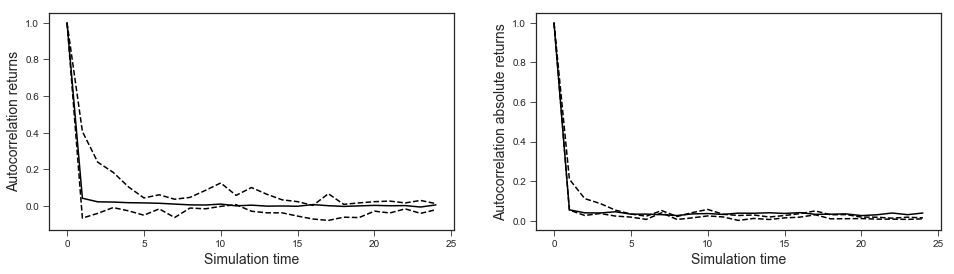

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

# 4 autocorrelation of returns
ax1.plot(autocors.index, autocors.mean(axis=1), 'k-', label='SIM Returns')
ax1.plot(autocors.index, autocors_lows, 'k--')
ax1.plot(autocors.index, autocors_highs, 'k--')
ax1.set_ylabel('Autocorrelation returns', fontsize='14')

ax2.plot(autocors.index, autocors.abs().mean(axis=1), 'k-', label='SIM Returns')
ax2.plot(autocors.index, autocors_abs_lower, 'k--')
ax2.plot(autocors.index, autocors_abs_upper, 'k--')
ax2.set_ylabel('Autocorrelation absolute returns', fontsize='14')

for ax in (ax1, ax2):
    ax.set_xlabel('Simulation time', fontsize='14')
    

fig.savefig('autocorrelation_returns.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

### Long memory:

In [28]:
sim_hursts = []
for col in prices[0]:
    H, c, data = compute_Hc(prices[0][col], kind='price', simplified=True)
    sim_hursts.append(H)

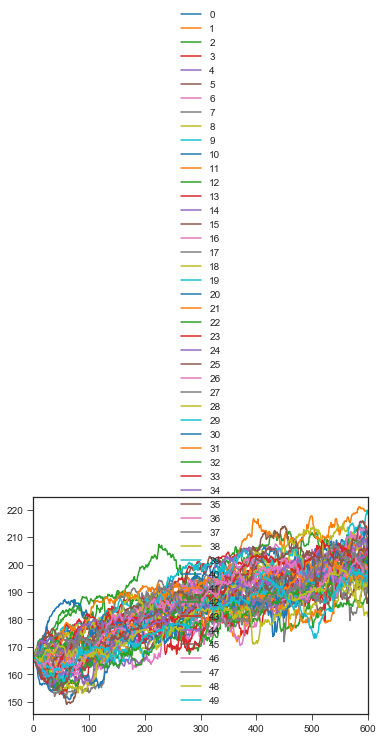

In [29]:
prices[0].plot()

In [67]:
confidence_interval(hursts) # np.mean(hursts)

(0.6891223821750319, 0.7425061214260906)

In [32]:
sim_hursts

[0.7427844803473646,
 0.6976103250206758,
 0.660623495880466,
 0.7574791147298847,
 0.6281157754123916,
 0.6562779399042885,
 0.6454992181071825,
 0.6723836426545584,
 0.6978565772470804,
 0.6739107058671097,
 0.662878818351964,
 0.7039720520249904,
 0.61621580264645,
 0.6756769238582451,
 0.7198146445998661,
 0.7707926442600381,
 0.7424075774480098,
 0.6304942867264683,
 0.6584294616527141,
 0.685320387810078,
 0.6776860790357271,
 0.6092870328284181,
 0.6335903901361276,
 0.610037878084506,
 0.670577065517504,
 0.6076499532526832,
 0.6911657411287846,
 0.6683628437764693,
 0.7526038626901499,
 0.6967258473912118,
 0.685819889624005,
 0.7229629574853126,
 0.6722186880322844,
 0.5243412343582123,
 0.7250561450273372,
 0.7371829044130733,
 0.7149841948641303,
 0.5947927483518279,
 0.628352947420441,
 0.6772493307302209,
 0.5575584081850952,
 0.6734966818971804,
 0.6533434697545599,
 0.7212591812116564,
 0.6541003285654139,
 0.7302638662237337,
 0.6813872224364993,
 0.660997021740577,
 0

In [33]:
np.mean(sim_hursts)

0.6725414399145561

# Model dynamics

fig with 
1. price to fundamentals, 
2. volume, 
3. returns, 
4. autocorrelation of returns

In [34]:
prices[0].pct_change()[0].autocorr(20)

0.026070961940061095

In [51]:
lower_c_price = []
upper_c_price = []
av_pf = []
for row in range(len(prices[0])-1):
    price_range = prices[0].iloc[row] / fundamentals[0].iloc[row]#fundamentals[s_idx].mean(axis=1)# / mc_fundamentals.iloc[row]
    lower, upper = confidence_interval(price_range) #, np.mean(price_range)
    av_pf.append(np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

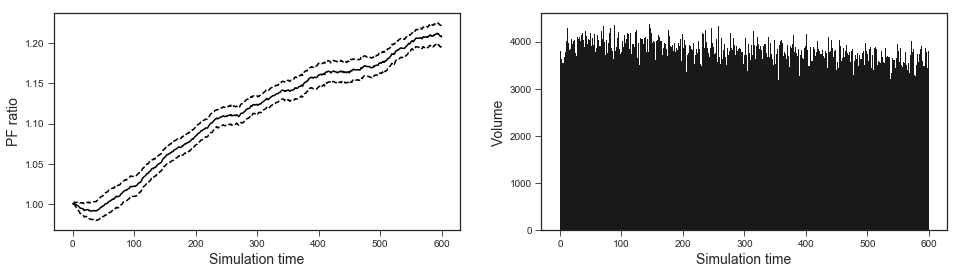

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

s_idx = 0

# 1 price to fundamentals
ax1.plot(prices[s_idx].index[:-1], av_pf, 'k-')
ax1.plot(prices[s_idx].index[:-1], lower_c_price, 'k--')
ax1.plot(prices[s_idx].index[:-1], upper_c_price, 'k--')

ax1.set_ylabel('PF ratio', fontsize='14')

# 2 volumes
ax2.bar(volumes[s_idx].index, volumes[s_idx].mean(axis=1), width=1.0, color='black', alpha=0.9)
ax2.set_ylabel('Volume', fontsize='14')


# # 3 returns
# ax3.plot(prices[0].index, prices[0].pct_change().mean(axis=1), 'k-')
# ax3.set_ylabel('Returns', fontsize='14')

# # 4 autocorrelation of returns
# ax4.plot(autocors.index, autocors.mean(axis=1), 'k-', label='SIM Returns')
# ax4.plot(autocors.index, lower_autocors, 'k--')
# ax4.plot(autocors.index, upper_autocors, 'k--')
# ax4.set_ylabel('Autocorrelation returns', fontsize='14')

for ax in (ax1, ax2):
    ax.set_xlabel('Simulation time', fontsize='14')
    

fig.savefig('baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [60]:
autocors.mean().mean()

0.047964444519017324

In [61]:
autocors.abs().mean().mean()

0.07450408217560263

Text(0.5, 0, 'Simulation time')

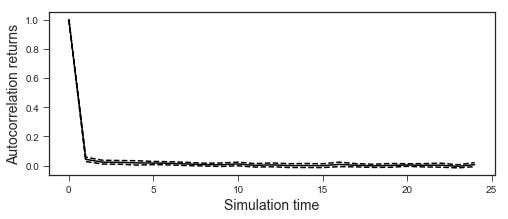

In [62]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,3))

s_idx = 0

# 1 abs autocorrelation of returns
ax1.plot(autocors.index, autocors.mean(axis=1), 'k-', label='SIM Returns')
ax1.plot(autocors.index, lower_autocors, 'k--')
ax1.plot(autocors.index, upper_autocors, 'k--')
ax1.set_ylabel('Autocorrelation returns', fontsize='14')

ax1.set_xlabel('Simulation time', fontsize='14')
    

#fig.savefig('baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [63]:
prices[0].pct_change().kurtosis().mean()

4.357464904618228